In [1]:
!pip install rouge-score nltk

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=99ef75f4db34b92581aff9c2552b0924d3e8177209f19f26e1920ffb61930e7c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
!pip install -U bitsandbytes
# !pip install accelerate bitsandbytes
# !pip install bitsandbytes-cuda110 bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 8.0 MB/s eta 0:00:00


In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from accelerate import init_empty_weights
import gc
import psutil
import numpy as np
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time  # Added missing import
from typing import Dict, List, Tuple

# Evaluating DistilGPT2

Loading distilgpt2-medical...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Successfully loaded distilgpt2-medical

Starting evaluation...

=== distilgpt2-medical Output for Case 1 ===

Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
           Animate history (see below) is a physical examination that has been performed to confirm or estimate any symptoms associated from an individual's initial exposure during use in this area prior on their own so as not to cause further risk for future exposures later than before.[1] A person can be diagnosed by using inhalation equipment such Asperger’s Breathalyzer if there have ever bee

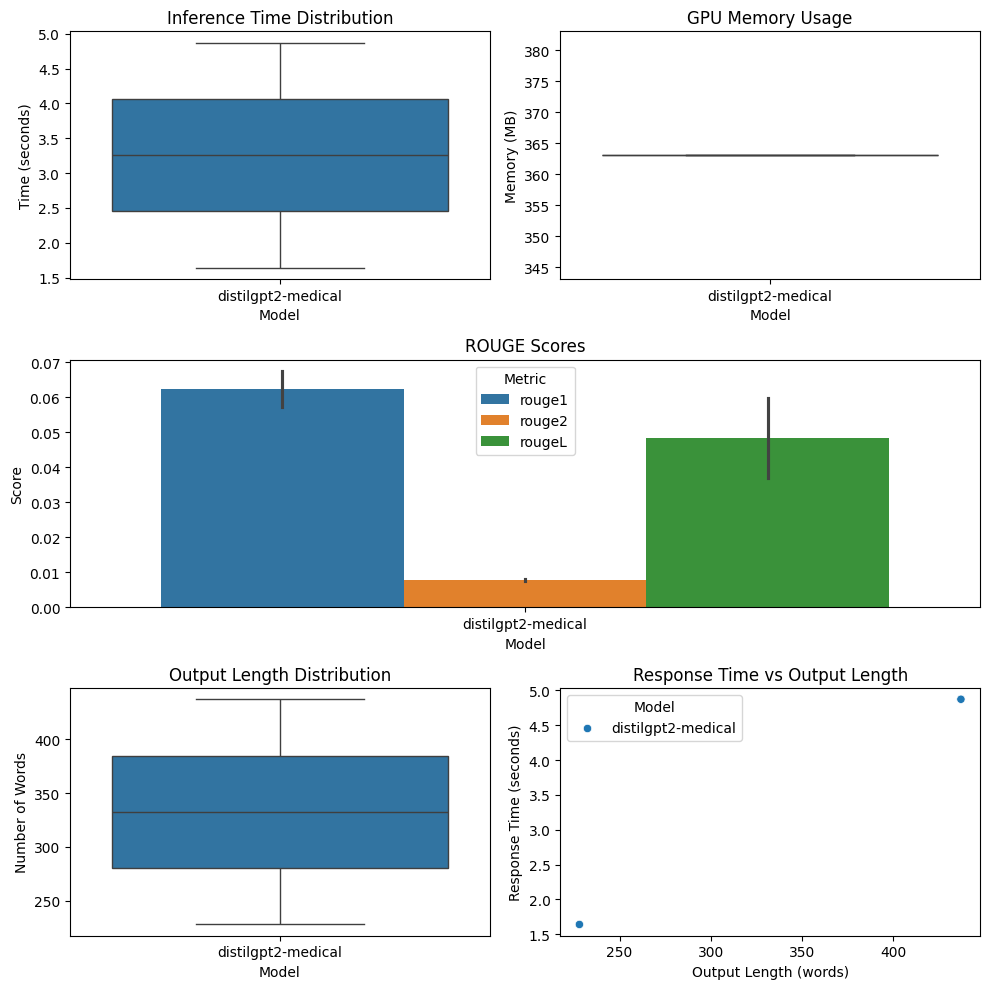

In [10]:
class ModelLoader:
    def __init__(self):
        self.models = {}
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

    def load_models(self):
        model_configs = {
            'distilgpt2-medical': {
                'path': "Apurva3509/distilgpt2-medical-finetuned",
                'use_4bit': False
            }
        }

        for model_name, config in model_configs.items():
            try:
                print(f"Loading {model_name}...")

                gc.collect()
                torch.cuda.empty_cache()

                if config['use_4bit']:
                    model = AutoModelForCausalLM.from_pretrained(
                        config['path'],
                        quantization_config=self.quantization_config,
                        device_map="auto",
                        torch_dtype=torch.float16
                    )
                else:
                    model = AutoModelForCausalLM.from_pretrained(
                        config['path'],
                        torch_dtype=torch.float16
                    ).to('cuda')

                tokenizer = AutoTokenizer.from_pretrained(config['path'])

                if tokenizer.pad_token is None:
                    tokenizer.pad_token = tokenizer.eos_token

                self.models[model_name] = (model, tokenizer)
                print(f"Successfully loaded {model_name}")

            except Exception as e:
                print(f"Error loading {model_name}: {str(e)}")

        return self.models

class ModelEvaluator:
    def __init__(self, models):
        self.models = models
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def evaluate_model(self, model_name, model, tokenizer, input_text, max_length=512):
        try:
            inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

            stopping_criteria = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id

            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.95,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=stopping_criteria,
                    eos_token_id=stopping_criteria,
                    min_length=100,
                    num_return_sequences=1
                )
            inference_time = time.time() - start_time

            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

            input_text = input_text.strip()
            if output_text.startswith(input_text):
                output_text = output_text[len(input_text):].strip()

            gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

            return {
                'output': output_text,
                'inference_time': inference_time,
                'gpu_memory': gpu_memory
            }

        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None

    def evaluate_all_models(self, test_cases, reference_answers):
        results = {
            'performance': [],
            'memory': [],
            'quality': [],
            'outputs': []
        }

        for model_name, (model, tokenizer) in self.models.items():
            for i, test_case in enumerate(test_cases):
                eval_result = self.evaluate_model(model_name, model, tokenizer, test_case)

                if eval_result:
                    results['outputs'].append({
                        'model': model_name,
                        'case': i+1,
                        'input': test_case,
                        'output': eval_result['output'],
                        'reference': reference_answers[i] if i < len(reference_answers) else None
                    })

                    if i < len(reference_answers):
                        scores = self.scorer.score(reference_answers[i], eval_result['output'])

                        results['performance'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'Time': eval_result['inference_time']
                        })

                        results['memory'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'Memory': eval_result['gpu_memory']
                        })

                        results['quality'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'rouge1': scores['rouge1'].fmeasure,
                            'rouge2': scores['rouge2'].fmeasure,
                            'rougeL': scores['rougeL'].fmeasure
                        })

                        print(f"\n=== {model_name} Output for Case {i+1} ===")
                        print("\nInput:")
                        print(test_case.strip())
                        print("\nGenerated Output:")
                        print(eval_result['output'])
                        print("\nReference Answer:")
                        print(reference_answers[i])
                        print(f"\nMetrics:")
                        print(f"Inference Time: {eval_result['inference_time']:.2f}s")
                        print(f"GPU Memory: {eval_result['gpu_memory']:.1f}MB")
                        print(f"ROUGE-1: {scores['rouge1'].fmeasure:.3f}")
                        print(f"ROUGE-2: {scores['rouge2'].fmeasure:.3f}")
                        print(f"ROUGE-L: {scores['rougeL'].fmeasure:.3f}")
                        print("-" * 80)

        return results

def analyze_outputs(results):
    output_analysis = {}

    for output in results['outputs']:
        model_name = output['model']
        if model_name not in output_analysis:
            output_analysis[model_name] = {
                'avg_length': [],
                'response_times': [],
                'rouge_scores': []
            }

        output_analysis[model_name]['avg_length'].append(len(output['output'].split()))

        perf_data = next(p for p in results['performance']
                        if p['Model'] == model_name and p['Case'] == output['case'])
        output_analysis[model_name]['response_times'].append(perf_data['Time'])

        quality_data = next(q for q in results['quality']
                          if q['Model'] == model_name and q['Case'] == output['case'])
        output_analysis[model_name]['rouge_scores'].append(quality_data['rouge1'])

    print("\n=== Output Analysis ===")
    for model_name, analysis in output_analysis.items():
        print(f"\n{model_name}:")
        print(f"Average output length: {np.mean(analysis['avg_length']):.1f} words")
        print(f"Average response time: {np.mean(analysis['response_times']):.2f}s")
        print(f"Average ROUGE-1 score: {np.mean(analysis['rouge_scores']):.3f}")
        print(f"Response time range: {min(analysis['response_times']):.2f}s - {max(analysis['response_times']):.2f}s")

    return output_analysis

def plot_results(results, output_analysis):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(3, 2)

    # Performance Plot
    ax1 = fig.add_subplot(gs[0, 0])
    perf_df = pd.DataFrame(results['performance'])
    sns.boxplot(data=perf_df, x='Model', y='Time', ax=ax1)
    ax1.set_title('Inference Time Distribution')
    ax1.set_ylabel('Time (seconds)')

    # Memory Plot
    ax2 = fig.add_subplot(gs[0, 1])
    mem_df = pd.DataFrame(results['memory'])
    sns.boxplot(data=mem_df, x='Model', y='Memory', ax=ax2)
    ax2.set_title('GPU Memory Usage')
    ax2.set_ylabel('Memory (MB)')

    # Quality Metrics Plot
    ax3 = fig.add_subplot(gs[1, :])
    quality_df = pd.DataFrame(results['quality'])
    quality_melted = pd.melt(quality_df,
                            id_vars=['Model', 'Case'],
                            value_vars=['rouge1', 'rouge2', 'rougeL'],
                            var_name='Metric',
                            value_name='Score')
    sns.barplot(data=quality_melted, x='Model', y='Score', hue='Metric', ax=ax3)
    ax3.set_title('ROUGE Scores')

    # Output Length Distribution
    ax4 = fig.add_subplot(gs[2, 0])
    length_data = []
    for model_name, analysis in output_analysis.items():
        for length in analysis['avg_length']:
            length_data.append({'Model': model_name, 'Length': length})
    length_df = pd.DataFrame(length_data)
    sns.boxplot(data=length_df, x='Model', y='Length', ax=ax4)
    ax4.set_title('Output Length Distribution')
    ax4.set_ylabel('Number of Words')

    # Response Time vs Output Length
    ax5 = fig.add_subplot(gs[2, 1])
    time_length_data = []
    for model_name, analysis in output_analysis.items():
        for time, length in zip(analysis['response_times'], analysis['avg_length']):
            time_length_data.append({
                'Model': model_name,
                'Time': time,
                'Length': length
            })
    time_length_df = pd.DataFrame(time_length_data)
    sns.scatterplot(data=time_length_df, x='Length', y='Time', hue='Model', ax=ax5)
    ax5.set_title('Response Time vs Output Length')
    ax5.set_xlabel('Output Length (words)')
    ax5.set_ylabel('Response Time (seconds)')

    plt.tight_layout()
    plt.show()

def main():
    test_cases = [
        """
        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        """,
        """
        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
        """
    ]

    reference_answers = [
        """
        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        """,
        """
        Differential diagnosis includes:
        1. Pulmonary Embolism
        2. Pneumothorax
        3. Pleurisy
        4. Acute Coronary Syndrome

        Immediate workup needed:
        1. D-dimer
        2. Chest X-ray
        3. ECG
        4. Cardiac enzymes
        """
    ]

    try:
        loader = ModelLoader()
        models = loader.load_models()

        if not models:
            print("No models were successfully loaded")
            return

        evaluator = ModelEvaluator(models)

        print("\nStarting evaluation...")
        results = evaluator.evaluate_all_models(test_cases, reference_answers)

        output_analysis = analyze_outputs(results)
        plot_results(results, output_analysis)

    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()

# Evaluating all 3 Models

In [21]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import time
import numpy as np
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc

Starting model evaluation...

Loading distilgpt2-medical...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Successfully loaded distilgpt2-medical

=== distilgpt2-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
           Viewing this page is not a complete list unless you have read these items carefully or in detail before starting any medical procedure on your own to prevent it from becoming an emergency condition that will result if they become serious enough for someone else (if there's no indication). The symptoms may be severe but rarely experienced because their illness has been treated without incident by other healthca

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Successfully loaded llama-medical

=== llama-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
         Answered by Dr.Laxman Aryal on February-27th -2015

Patient has symptoms which can be related to Tuberculosis (TB), Lung cancer or Chronic Obstructive Pulmonary Disease(COPD). 

The patient is at risk for TB due to his history as a smoker.

There should not have any chest radiography done before bronchoscopy in patients who may need further evaluation because their clinical condition requires it eg; those that develop res

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.



Loading gemma-medical...
Successfully loaded gemma-medical

=== gemma-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
t', 'The provided term does not correspond any known disease.')) }}  model The differential diagnosis includes lung cancer or tuberculosis.


Model A chest x ray may show an enlarged mediastinum as well if there was significant involvement in either primary lesion within it (e g solitary metastasis). On CT scan multiple nodules can be seen throughout both lungs which typically have irregular borders on ul

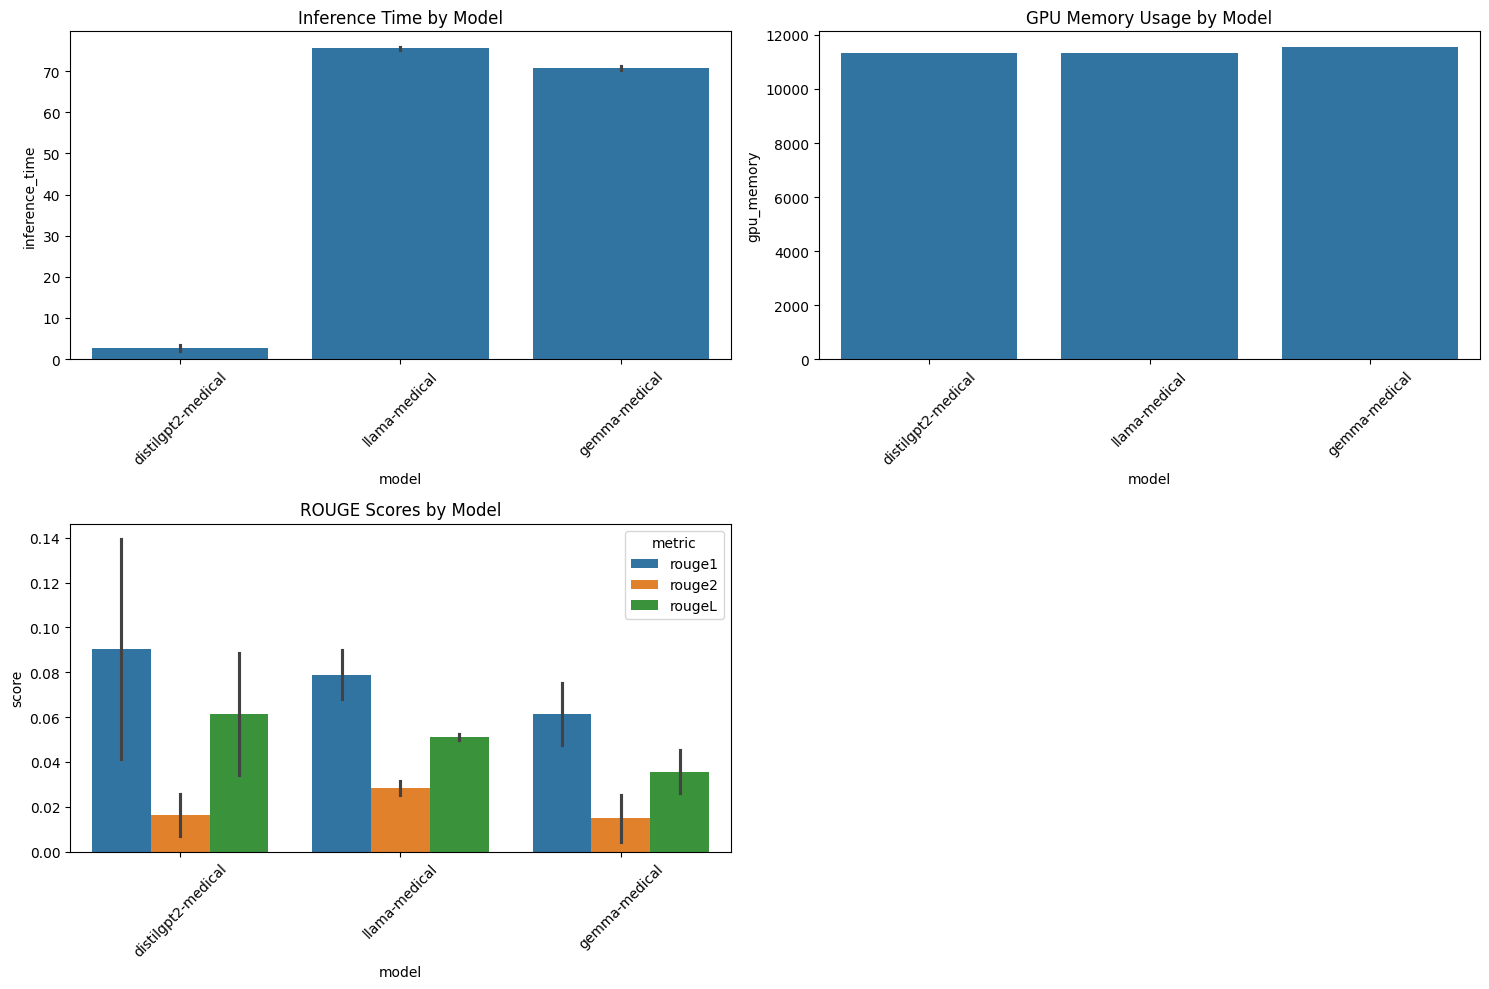


Evaluation complete!


In [22]:
class ModelManager:
    def __init__(self):
        self.models = {}
        self.bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

    def load_model(self, model_name, model_path, use_quantization=False):
        try:
            print(f"\nLoading {model_name}...")
            gc.collect()
            torch.cuda.empty_cache()

            if use_quantization:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    quantization_config=self.bnb_config,
                    device_map="auto",
                    torch_dtype=torch.float16
                )
            else:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    torch_dtype=torch.float16
                ).to('cuda')

            tokenizer = AutoTokenizer.from_pretrained(model_path)
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token

            self.models[model_name] = (model, tokenizer)
            print(f"Successfully loaded {model_name}")
            return True

        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
            return False

    def evaluate_model(self, model_name, input_text, max_length=512):
        if model_name not in self.models:
            return None

        model, tokenizer = self.models[model_name]
        try:
            inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.95,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            inference_time = time.time() - start_time

            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

            return {
                'output': output_text,
                'inference_time': inference_time,
                'gpu_memory': gpu_memory
            }
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None

def evaluate_models():
    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Test cases
    test_cases = [
        """
        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        """,
        """
        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
        """
    ]

    reference_answers = [
        """
        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        """,
        """
        Differential diagnosis includes:
        1. Pulmonary Embolism
        2. Pneumothorax
        3. Pleurisy
        4. Acute Coronary Syndrome

        Immediate workup needed:
        1. D-dimer
        2. Chest X-ray
        3. ECG
        4. Cardiac enzymes
        """
    ]

    # Initialize model manager
    manager = ModelManager()

    # Model configurations
    models_config = {
        'distilgpt2-medical': {
            'path': "Apurva3509/distilgpt2-medical-finetuned",
            'quantize': False
        },
        'llama-medical': {
            'path': "Apurva3509/llama-3-8b-Instruct-bnb-4bit-medical",
            'quantize': True
        },
        'gemma-medical': {
            'path': "Apurva3509/gemma-1.1-7b-it-bnb-4bit-medical",
            'quantize': True
        }
    }

    results = []

    # Load and evaluate each model
    for model_name, config in models_config.items():
        if manager.load_model(model_name, config['path'], config['quantize']):
            model_results = []

            for i, test_case in enumerate(test_cases):
                eval_result = manager.evaluate_model(model_name, test_case)

                if eval_result:
                    scores = scorer.score(reference_answers[i], eval_result['output'])

                    print(f"\n=== {model_name} Output for Case {i+1} ===")
                    print(f"Input:\n{test_case.strip()}")
                    print(f"\nGenerated Output:\n{eval_result['output']}")
                    print(f"\nReference Answer:\n{reference_answers[i]}")
                    print(f"\nMetrics:")
                    print(f"Inference Time: {eval_result['inference_time']:.2f}s")
                    print(f"GPU Memory: {eval_result['gpu_memory']:.1f}MB")
                    print(f"ROUGE-1: {scores['rouge1'].fmeasure:.3f}")
                    print(f"ROUGE-2: {scores['rouge2'].fmeasure:.3f}")
                    print(f"ROUGE-L: {scores['rougeL'].fmeasure:.3f}")
                    print("-" * 80)

                    model_results.append({
                        'model': model_name,
                        'case': i+1,
                        'inference_time': eval_result['inference_time'],
                        'gpu_memory': eval_result['gpu_memory'],
                        'rouge1': scores['rouge1'].fmeasure,
                        'rouge2': scores['rouge2'].fmeasure,
                        'rougeL': scores['rougeL'].fmeasure
                    })

            results.extend(model_results)

            # Clear memory after each model
            gc.collect()
            torch.cuda.empty_cache()

    return pd.DataFrame(results)

def plot_results(results_df):
    plt.figure(figsize=(15, 10))

    # Plot inference times
    plt.subplot(2, 2, 1)
    sns.barplot(data=results_df, x='model', y='inference_time')
    plt.title('Inference Time by Model')
    plt.xticks(rotation=45)

    # Plot GPU memory usage
    plt.subplot(2, 2, 2)
    sns.barplot(data=results_df, x='model', y='gpu_memory')
    plt.title('GPU Memory Usage by Model')
    plt.xticks(rotation=45)

    # Plot ROUGE scores
    plt.subplot(2, 2, 3)
    rouge_data = results_df.melt(
        id_vars=['model'],
        value_vars=['rouge1', 'rouge2', 'rougeL'],
        var_name='metric',
        value_name='score'
    )
    sns.barplot(data=rouge_data, x='model', y='score', hue='metric')
    plt.title('ROUGE Scores by Model')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Starting model evaluation...")
    results_df = evaluate_models()
    print("\nPlotting results...")
    plot_results(results_df)
    print("\nEvaluation complete!")

# Evaluating all models with Bert and Bleu values

In [25]:
!pip install bert-score>=0.3.10

In [26]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import time
import numpy as np
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import bert_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Starting model evaluation...

Loading distilgpt2-medical...
Successfully loaded distilgpt2-medical


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== distilgpt2-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
          Diagnosis - a person who is in an emergency room or hospital where they have been exposed to air pollution from their lungs by inhalation due on inhaled aerosols (air pollutants) that cause small amounts of lung cancer throughout normal life as well as respiratory disease such when it comes to coughing up at work for other activities like occupational hygiene management etc. This includes sleeping roughs under blankets/wetches during periods caused 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== distilgpt2-medical Output for Case 2 ===
Input:
Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?

Generated Output:

        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
          The patient's primary cause and symptoms are usually mild to moderate (e .g., headache). We have no idea what may be related when one hears a voice or sounds that can come from someone else’s ear in person while hearing these voices on their own without realizing it has occurred before—unless you were standing near somebody who was talking about this conversation for some reason during an emergency room visit by another friend at home after having had difficulty spea

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== distilgpt2-medical Output for Case 3 ===
Input:
Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?

Generated Output:

        Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?
          A few of us have been in intensive care for over 3 years now to help get rid that excessive blood glucose can lead our patients into the emergency room or hospital! This was my first time doing so but it wasn't until after I had gotten through some chemotherapy treatments during treatment from an experienced physician who has a very high concentration (>0%) systolic heart rate as well!! We are still waiting on y

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Successfully loaded llama-medical


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== llama-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        


Medical history (current):
    Hypertension 
Cardiovascular disease  
Diabetes mellitus   Hypercholesterolemia  

Family medical information:

Sister had breast cancer in her late forties.

Allerges to sulfonamides

Social history:

Smoking
Current or past alcohol use

Physical exam:
Vital signs were normal.
There was no pallor.

The patient's height is approximately6 ft tall; his body mass index is about29 kg/m2.
His skin appears pale but has scattered

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== llama-medical Output for Case 2 ===
Input:
Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?

Generated Output:

        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
         Answer:

    Aortic dissection 
Angina pectoris or myocardial infarction Pulmonary embolism Pneumonia Acute pericarditis and/or tamponade 

Differential Diagnosis for Chest Discomfort in Women (2nd edn). Philadelphia PA; Lippincott Williams & Wilkins - Page e5-6

Chest discomfort that worsens during exercise may be caused by a cardiac cause as opposed to an non-cardiac one if it persists after cessation from physical activity.

In patients who are younger than age fifty ye

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== llama-medical Output for Case 3 ===
Input:
Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?

Generated Output:

        Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?
         a) Increase the dose of metformin to improve glycemic control   b) Perform eye examination for retinal complications    c) Monitor blood glucose levels closely d) Refer him or her urgently eucalyptus treatment is necessary f) Start insulin therapy g) Treat hypoglycaemia h)
            i- Insulin sensitivity j-hypotension k-mitral regurgitation l-
                m -microalbumuria n--non-healing ulcer o-onset pericardi

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.



Loading gemma-medical...
Error loading gemma-medical: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

Plotting results...


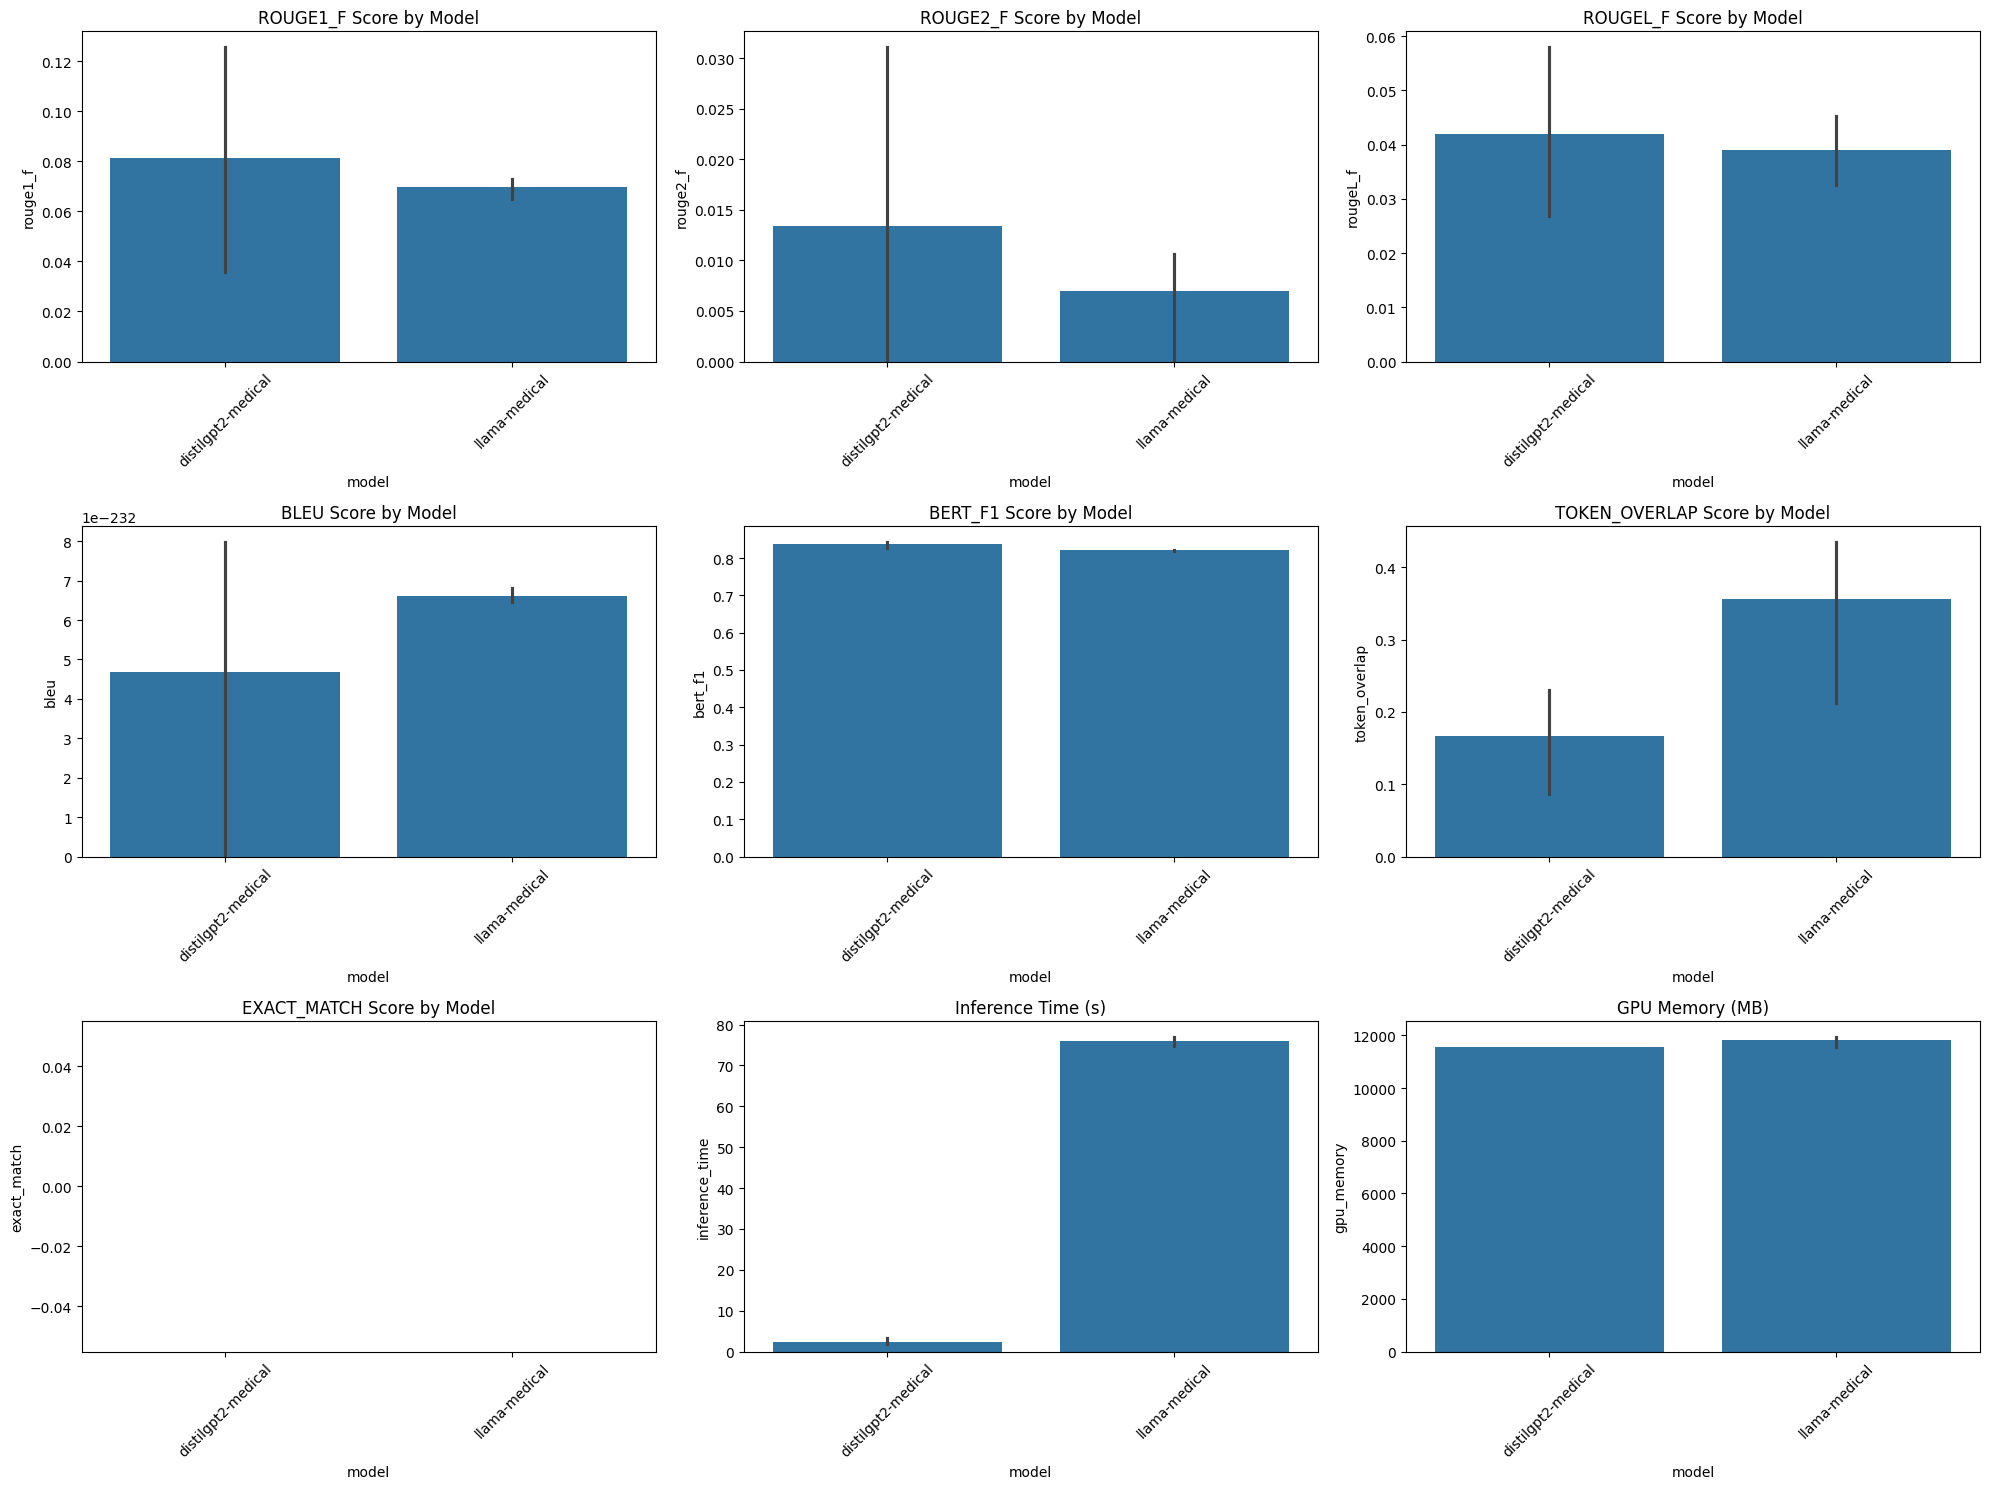


Generating summary statistics...

=== Summary Statistics ===
                   rouge1_f        rouge2_f        rougeL_f        bleu      bert_f1        token_overlap        exact_match      inference_time        gpu_memory        
                       mean    std     mean    std     mean    std mean  std    mean    std          mean    std        mean  std           mean    std       mean     std
model                                                                                                                                                                     
distilgpt2-medical    0.081  0.045    0.013  0.016    0.042  0.016  0.0  0.0   0.837  0.009         0.167  0.073         0.0  0.0          2.363  0.880  11557.499    0.00
llama-medical         0.070  0.004    0.007  0.006    0.039  0.006  0.0  0.0   0.821  0.001         0.357  0.125         0.0  0.0         75.936  1.077  11812.403  215.62

=== Best Performing Models ===
rouge1_f: distilgpt2-medical (0.126)
rouge2_f: dist

In [27]:
class ModelManager:
    def __init__(self):
        self.models = {}
        self.bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def load_model(self, model_name, model_path, use_quantization=False):
        try:
            print(f"\nLoading {model_name}...")
            gc.collect()
            torch.cuda.empty_cache()

            if use_quantization:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    quantization_config=self.bnb_config,
                    device_map="auto",
                    torch_dtype=torch.float16
                )
            else:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    torch_dtype=torch.float16
                ).to('cuda')

            tokenizer = AutoTokenizer.from_pretrained(model_path)
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token

            self.models[model_name] = (model, tokenizer)
            print(f"Successfully loaded {model_name}")
            return True

        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
            return False

    def calculate_metrics(self, reference, prediction):
        try:
            # ROUGE scores
            rouge_scores = self.rouge_scorer.score(reference, prediction)

            # BLEU score
            reference_tokens = [reference.split()]
            prediction_tokens = prediction.split()
            bleu = sentence_bleu(reference_tokens, prediction_tokens)

            # BERTScore
            P, R, F1 = bert_score.score([prediction], [reference], lang='en', verbose=False)

            # Exact Match
            exact_match = 1.0 if prediction.strip() == reference.strip() else 0.0

            # Token overlap (custom metric)
            ref_tokens = set(reference.lower().split())
            pred_tokens = set(prediction.lower().split())
            token_overlap = len(ref_tokens.intersection(pred_tokens)) / len(ref_tokens)

            return {
                'rouge1_f': rouge_scores['rouge1'].fmeasure,
                'rouge2_f': rouge_scores['rouge2'].fmeasure,
                'rougeL_f': rouge_scores['rougeL'].fmeasure,
                'bleu': bleu,
                'bert_precision': P.item(),
                'bert_recall': R.item(),
                'bert_f1': F1.item(),
                'exact_match': exact_match,
                'token_overlap': token_overlap
            }
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            return None

    def evaluate_model(self, model_name, input_text, max_length=512):
        if model_name not in self.models:
            return None

        model, tokenizer = self.models[model_name]
        try:
            inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.95,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            inference_time = time.time() - start_time

            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

            return {
                'output': output_text,
                'inference_time': inference_time,
                'gpu_memory': gpu_memory
            }
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None

def evaluate_models():
    # Test cases
    test_cases = [
        """
        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        """,
        """
        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
        """,
        """
        Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?
        """
    ]

    reference_answers = [
        """
        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        """,
        """
        Differential diagnosis includes:
        1. Pulmonary Embolism
        2. Pneumothorax
        3. Pleurisy
        4. Acute Coronary Syndrome

        Immediate workup needed:
        1. D-dimer
        2. Chest X-ray
        3. ECG
        4. Cardiac enzymes
        """,
        """
        Management plan:
        1. Adjust diabetes medications
        2. Check blood pressure and kidney function
        3. Review diet and exercise
        4. Screen for complications

        Immediate steps:
        1. HbA1c test
        2. Comprehensive metabolic panel
        3. Urine microalbumin
        4. Referral to diabetes educator
        """
    ]

    # Initialize model manager
    manager = ModelManager()

    # Model configurations
    models_config = {
        'distilgpt2-medical': {
            'path': "Apurva3509/distilgpt2-medical-finetuned",
            'quantize': False
        },
        'llama-medical': {
            'path': "Apurva3509/llama-3-8b-Instruct-bnb-4bit-medical",
            'quantize': True
        },
        'gemma-medical': {
            'path': "Apurva3509/gemma-1.1-7b-it-bnb-4bit-medical",
            'quantize': True
        }
    }

    results = []

    # Load and evaluate each model
    for model_name, config in models_config.items():
        if manager.load_model(model_name, config['path'], config['quantize']):
            model_results = []

            for i, test_case in enumerate(test_cases):
                eval_result = manager.evaluate_model(model_name, test_case)

                if eval_result:
                    metrics = manager.calculate_metrics(reference_answers[i], eval_result['output'])

                    if metrics:
                        result_dict = {
                            'model': model_name,
                            'case': i+1,
                            'inference_time': eval_result['inference_time'],
                            'gpu_memory': eval_result['gpu_memory'],
                            **metrics
                        }

                        model_results.append(result_dict)

                        print(f"\n=== {model_name} Output for Case {i+1} ===")
                        print(f"Input:\n{test_case.strip()}")
                        print(f"\nGenerated Output:\n{eval_result['output']}")
                        print(f"\nReference Answer:\n{reference_answers[i]}")
                        print(f"\nMetrics:")
                        for metric, value in metrics.items():
                            print(f"{metric}: {value:.3f}")
                        print(f"Inference Time: {eval_result['inference_time']:.2f}s")
                        print(f"GPU Memory: {eval_result['gpu_memory']:.1f}MB")
                        print("-" * 80)

            results.extend(model_results)

            # Clear memory after each model
            gc.collect()
            torch.cuda.empty_cache()

    return pd.DataFrame(results)

def plot_results(results_df):
    metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f', 'bleu', 'bert_f1',
               'token_overlap', 'exact_match']

    n_metrics = len(metrics)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols

    plt.figure(figsize=(20, 5*n_rows))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.barplot(data=results_df, x='model', y=metric)
        plt.title(f'{metric.upper()} Score by Model')
        plt.xticks(rotation=45)

    # Add performance metrics
    plt.subplot(n_rows, n_cols, n_metrics + 1)
    sns.barplot(data=results_df, x='model', y='inference_time')
    plt.title('Inference Time (s)')
    plt.xticks(rotation=45)

    plt.subplot(n_rows, n_cols, n_metrics + 2)
    sns.barplot(data=results_df, x='model', y='gpu_memory')
    plt.title('GPU Memory (MB)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def print_summary_statistics(results_df):
    print("\n=== Summary Statistics ===")
    metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f', 'bleu', 'bert_f1',
               'token_overlap', 'exact_match', 'inference_time', 'gpu_memory']

    summary = results_df.groupby('model')[metrics].agg(['mean', 'std']).round(3)
    print(summary.to_string())

    # Print best model for each metric
    print("\n=== Best Performing Models ===")
    for metric in metrics:
        best_model = results_df.loc[results_df[metric].idxmax()]
        print(f"{metric}: {best_model['model']} ({best_model[metric]:.3f})")

if __name__ == "__main__":
    # First install required packages
    # !pip install transformers accelerate bitsandbytes rouge-score bert-score torch pandas seaborn nltk

    print("Starting model evaluation...")
    results_df = evaluate_models()

    print("\nPlotting results...")
    plot_results(results_df)

    print("\nGenerating summary statistics...")
    print_summary_statistics(results_df)

    print("\nEvaluation complete!")